In [76]:
# 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
# 2. там поле conversion - это целевая переменная, а offer - коммуникация. 
# Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду 
# (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, 
# а все остальные - наличие.
# 3. сделать разбиение набора данных не тренировочную и тестовую выборки
# 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
# 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), 
# модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
# 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
# 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
# 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета 
# (конверсии - поле conversion) от значения uplift: 
#     1) сделать прогноз и получить uplift для тестовой выборки 
#     2) отсортировать тестовую выборку по uplift по убыванию 
#     3) разбить на децили (pandas qcut вам в помощь) 
#     4) для каждого дециля посчитать среднюю conversion
# 9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [77]:
%matplotlib inline

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
# !pip install scikit-uplift==0.2.0
# !pip install catboost
# !pip install causalml
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from catboost import CatBoostClassifier
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [78]:
# Чтение данных
df = pd.read_csv('data.csv')

In [79]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [80]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [81]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [82]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [83]:
dict_ = {'Buy One Get One':1, 'Discount':1, 'No Offer':0}
df = df.replace({'treatment': dict_})

In [84]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [85]:
df['zip_code'] = df['zip_code'].astype(str)
df['channel'] = df['channel'].astype(str)

In [86]:
features = df.columns[:-2]
target = df['target']
treatment = df['treatment']

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df[features], target, treatment, test_size=0.3, random_state=42)

In [87]:
X_train.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9656,7,434.35,1,0,Urban,1,Web
63037,1,376.59,1,0,Surburban,0,Multichannel
31405,3,140.34,0,1,Urban,1,Phone


In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44800 entries, 9656 to 56422
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        44800 non-null  int64  
 1   history        44800 non-null  float64
 2   used_discount  44800 non-null  int64  
 3   used_bogo      44800 non-null  int64  
 4   zip_code       44800 non-null  object 
 5   is_referral    44800 non-null  int64  
 6   channel        44800 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.7+ MB


In [89]:
# К полям:
# zip_code, channel применим OHE-кодирование
# history - standardScaler
# recency, used_discount, used_bogo, is_referral, treatment - оставим как есть

continuos_cols = ['history']
cat_cols = ['zip_code', 'channel']
base_cols = ['recency', 'used_discount', 'used_bogo', 'is_referral']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [90]:
# Объединим все трансформеры с помощью FeatureUnion
feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

array([[ 0.75403071,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.52773036,  0.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.39788353,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.9819766 ,  1.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [-0.66453869,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 2.13769124,  0.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ]])

In [91]:
# Сводная таблица по моделям
table_comp = pd.DataFrame({'Model': [], 
                           'uplift@10%': [], 
                           'uplift@20%': []})

In [92]:
# Сформируем список итоговых фичей
def get_features_transformed(model):

    features_transformed = []

    for i in range(len(model[0].transformer_list)):
        if model[0].transformer_list[i][0] in cat_cols:
            temp = model.named_steps['features'].transformer_list[i][1].named_steps['ohe'].columns
            [features_transformed.append(i) for i in temp]
        else:
            features_transformed.append(model[0].transformer_list[i][1][0].key)
    features_transformed.append('treatment')
    return features_transformed

#### 1. Одна модель с признаком коммуникации
Модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

uplift@10%: 0.0947
uplift@20%: 0.1002


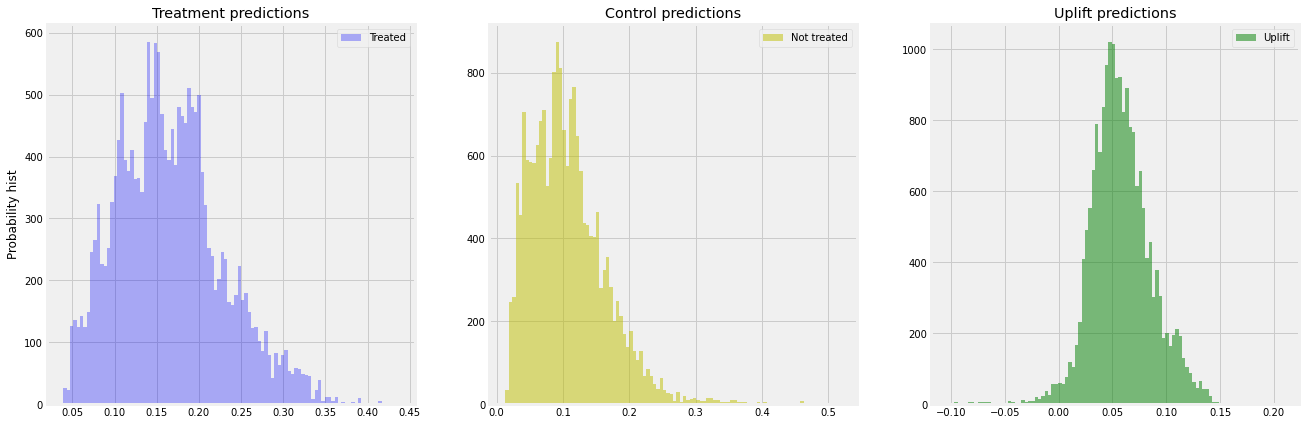

In [93]:
# Добавим модель 
uplift_sm = Pipeline([
    ('features', feats),
    ('uplift_model', SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True)))])

# Обучим пайплайн на тренировочном датасете
uplift_sm = uplift_sm.fit(X_train, y_train, uplift_model__treatment=treat_train)
y_preds_uplift_sm = uplift_sm.predict(X_test)

uplift_sm_score_10 = uplift_at_k(y_true=y_test, uplift=y_preds_uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
uplift_sm_score_20 = uplift_at_k(y_true=y_test, uplift=y_preds_uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {uplift_sm_score_10:.4f}\nuplift@20%: {uplift_sm_score_20:.4f}')

table_comp.loc[0] = ['SoloModel', uplift_sm_score_10, uplift_sm_score_20]

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = uplift_sm[1].trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = uplift_sm[1].ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [94]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
uplift_sm_fi = pd.DataFrame({
    'feature_name': get_features_transformed(uplift_sm),
    'feature_score': uplift_sm[1].estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)


uplift_sm_fi

,feature_name,feature_score
0,is_referral,18.381336
1,recency,17.820598
2,treatment,15.292646
3,history,15.230023
4,used_bogo,9.613481
5,used_discount,6.722438
6,zip_code_Rural,5.279555
7,channel_Web,4.502269
8,zip_code_Urban,4.165790
9,channel_Phone,1.793670


#### 2. Трансформация классов
Метод заключается в прогнозировании измененного таргета.

![ab_split](../uplift5.png "uplift5")

In [95]:
uplift_ct = Pipeline([
    ('features', feats),
    ('class_trans', ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True)))])

uplift_ct = uplift_ct.fit(X_train, y_train, class_trans__treatment=treat_train)
y_preds_uplift_ct = uplift_ct.predict(X_test)

uplift_ct_score_10 = uplift_at_k(y_true=y_test, uplift=y_preds_uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
uplift_ct_score_20 = uplift_at_k(y_true=y_test, uplift=y_preds_uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {uplift_ct_score_10:.4f}\nuplift@20%: {uplift_ct_score_20:.4f}')

table_comp.loc[1] = ['ClassTransformation', uplift_ct_score_10, uplift_ct_score_20]

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


uplift@10%: 0.1026
uplift@20%: 0.1018


#### 3. Две независимые модели
Подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

uplift@10%: 0.0869
uplift@20%: 0.0892


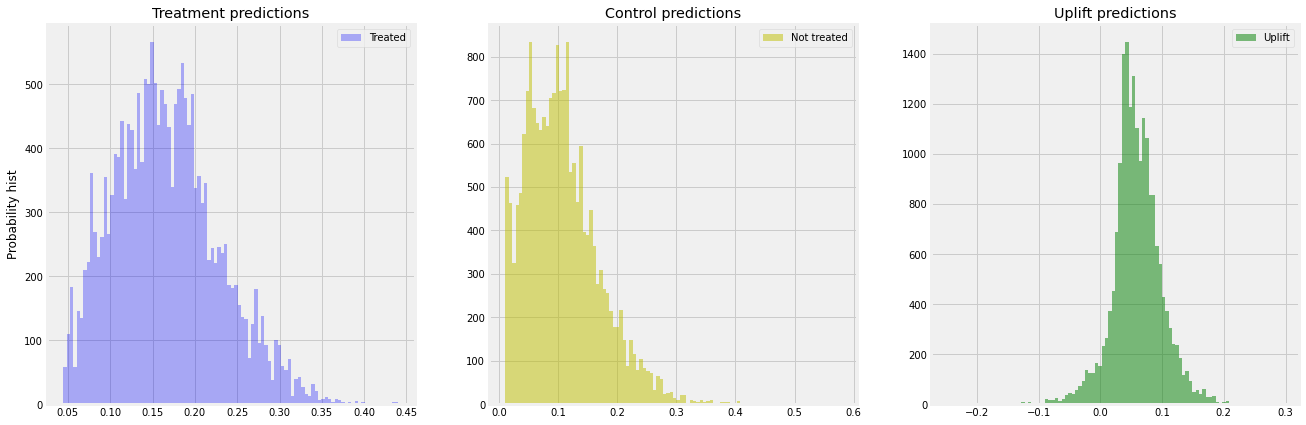

In [96]:
uplift_tm = Pipeline([
    ('features', feats),
    ('two_models', TwoModels(estimator_trmnt=CatBoostClassifier(iterations=20, random_state=42, silent=True),
                             estimator_ctrl=CatBoostClassifier(iterations=20, random_state=42, silent=True), 
                             method='vanilla'))])

uplift_tm = uplift_tm.fit(X_train, y_train, two_models__treatment=treat_train)
y_preds_uplift_tm = uplift_tm.predict(X_test)


uplift_tm_score_10 = uplift_at_k(y_true=y_test, uplift=y_preds_uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
uplift_tm_score_20 = uplift_at_k(y_true=y_test, uplift=y_preds_uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {uplift_tm_score_10:.4f}\nuplift@20%: {uplift_tm_score_20:.4f}')

table_comp.loc[2] = ['TwoModels', uplift_tm_score_10, uplift_tm_score_20]

plot_uplift_preds(trmnt_preds=uplift_tm[1].trmnt_preds_, ctrl_preds=uplift_tm[1].ctrl_preds_);

In [97]:
table_comp

,Model,uplift@10%,uplift@20%
0,SoloModel,0.094747,0.100198
1,ClassTransformation,0.102621,0.101832
2,TwoModels,0.086891,0.089220


**Вывод:** Модель с трансформацией класса сработала лучше всего.

#### 4. Вариант с деревом решений

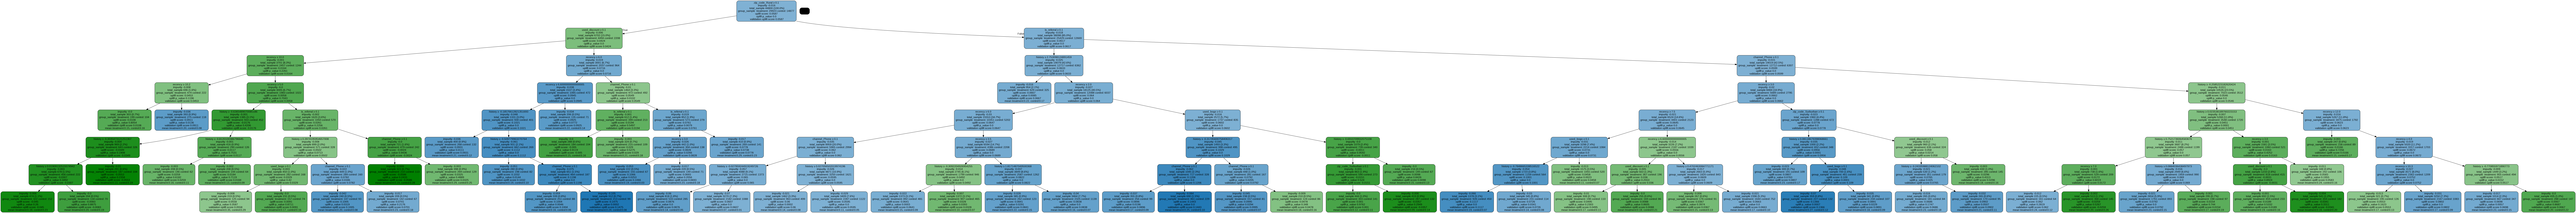

In [98]:
# Сформируем названия обработанных признаков
features_pipe = get_features_transformed(uplift_sm)[:-1]

# Сформируем датасет для дерева
X_train_tree = pd.DataFrame(feature_processing.fit_transform(X_train), columns=features_pipe)

uplift_tree = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_tree.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features_pipe)
Image(graph.create_png())

In [99]:
# Save the graph as pdf
# graph.write_pdf("tbc.pdf")
# Save the graph as png
graph.write_png("tbc.png")

True